In [1]:
# Import Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import statistics
import fastcluster
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
from itertools import permutations
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors

In [2]:
yeast = pd.read_csv('raw_cellcycle_384_17.txt', sep="\s+")
yeast_noindex = pd.read_csv('raw_cellcycle_384_17.txt', sep="\s+") 
yeast_columns = yeast_noindex.columns

categorical_features = ['Main','Gp']
numerical_features = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9',
                       'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17']
cat_data = yeast_noindex[categorical_features]

scaler = MinMaxScaler(feature_range=(-1, 1))
x = pd.DataFrame(scaler.fit_transform(yeast_noindex[numerical_features]))
x.columns = numerical_features
x_comb = pd.concat([cat_data, x], axis=1)
print(f'\n----> SCALED DATASET : \n\n{x_comb}')
s_row, s_col = x.shape

print(f'\n*\tSamples : {s_row}, Dimensions : {len(yeast_noindex.columns)}')

#sns.pairplot(data=x_comb, hue='diagnosis', height=2)
#plt.plot()


----> SCALED DATASET : 

        Main  Gp        c1        c2        c3        c4        c5        c6  \
0    YDL179w   1 -0.779939 -0.815516 -0.929740 -0.891010 -0.850285 -0.663037   
1    YLR079w   1 -0.576900 -0.642028 -0.811209 -0.817734 -0.722539 -0.626361   
2    YER111c   1 -0.899088 -0.861943 -0.903459 -0.943350 -0.951993 -0.946132   
3    YBR200w   1 -0.689970 -0.640806 -0.906141 -0.912562 -0.886086 -0.817765   
4    YJL194w   1 -0.910030 -0.701894 -0.936712 -0.953202 -0.922701 -0.863610   
..       ...  ..       ...       ...       ...       ...       ...       ...   
379  YOL070c   5 -0.497872 -0.533293 -0.762403 -0.757389 -0.680228 -0.332951   
380  YLR297W   5  0.381155 -0.208308 -0.607938 -0.482759 -0.248983 -0.093410   
381  YHL028W   5 -1.000000 -1.000000 -1.000000 -1.000000 -0.994304 -0.923209   
382  YHR151C   5 -0.956231 -0.945021 -0.980156 -0.971059 -0.977217 -0.962178   
383  YNL058C   5 -0.652280 -0.699450 -0.822473 -0.794335 -0.693247 -0.340974   

           c7

In [3]:
## ----------- MEDIAN ABSOLUTE DEVIATION (MAD) correlation matrix ---------------

def compute_median_absolute_deviation(df):
    return df.apply(lambda col: np.absolute(col - col.median()))

def generate_corr_elems(columns):
    comb = permutations(columns, 2)
    perms = list(comb)
    diag = [(col, col) for col in columns]
    return diag + perms

def compute_corr_matrix_values(df, corr_elems):
    corr_values = []
    for elem in corr_elems:
        corr_values.append(df[elem[0]].append(df[elem[1]], ignore_index=True).median(axis=0))
    return corr_values

def construct_corr_matrix(corr_values, num_columns):
    matrix = np.diag(corr_values[:num_columns])
    k = 0
    for i in range(num_columns):
        for j in range(num_columns):
            if i != j:
                matrix[i, j] = corr_values[num_columns:][k]
                k += 1
    return matrix

# Compute the Median Absolute Deviation
x_MAD = compute_median_absolute_deviation(x)
print(f'\n ---> Median Absolute Deviation : \n\n{x_MAD}')

# Generate the correlation matrix elements
corr_elems = generate_corr_elems(x_MAD.columns)
print(f'\n ---> The elements of the corr matrix are : \n\n{corr_elems}')

# Compute the correlation matrix values
corr_values = compute_corr_matrix_values(x_MAD, corr_elems)
print(f'\n ---> The values of the corr_elems are : \n')
for i, value in zip(corr_elems, corr_values):
    print(f'*The median of the columns ({i[0]},{i[1]}) -> {value}')

# Construct the correlation matrix
corr_matrix = construct_corr_matrix(corr_values, x_MAD.shape[1])
print(f'\n ---> Correlation matrix : \n\n{corr_matrix}')


 ---> Median Absolute Deviation : 

           c1        c2        c3        c4        c5        c6        c7  \
0    0.008511  0.059255  0.068651  0.034483  0.020342  0.101433  0.072683   
1    0.211550  0.114233  0.049879  0.038793  0.107404  0.138109  0.075610   
2    0.110638  0.105681  0.042371  0.086823  0.122050  0.181662  0.141951   
3    0.098480  0.115455  0.045052  0.056034  0.056143  0.053295  0.041463   
4    0.121581  0.054368  0.075623  0.096675  0.092758  0.099140  0.084390   
..        ...       ...       ...       ...       ...       ...       ...   
379  0.290578  0.222969  0.098686  0.099138  0.149715  0.431519  0.548780   
380  1.169605  0.547954  0.253151  0.373768  0.580960  0.671060  1.100000   
381  0.211550  0.243739  0.138911  0.143473  0.164361  0.158739  0.025854   
382  0.167781  0.188760  0.119067  0.114532  0.147274  0.197708  0.107805   
383  0.136170  0.056811  0.038616  0.062192  0.136697  0.423496  0.707805   

           c8        c9       c10     

In [4]:
# Eigen Value & Eigen Vector Decomposition

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

# Sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Print the sorted eigenvalues and eigenvectors
print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)

eig_vals_total = sum(eigenvalues)
explained_variance = [(i / eig_vals_total)*100 for i in eigenvalues]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)
print('\nExplained variance             : {}'.format(explained_variance))

print('Cumulative explained variance  : {}'.format(cum_explained_variance))

Eigenvalues:
[ 1.87306278e+00  3.46046070e-02  8.68195845e-03  5.28210431e-03
  2.09006992e-03  1.49751841e-03  8.14223714e-04 -3.33538786e-04
 -5.27148432e-04 -9.44135187e-04 -1.54295206e-03 -2.26449666e-03
 -2.44057438e-03 -3.52244504e-03 -4.21711828e-03 -5.65272666e-03
 -1.17054738e-02]

Eigenvectors:
[[ 0.23765327  0.0738514   0.29232093 -0.03603482 -0.31168563  0.01316879
   0.01010915  0.0564459   0.59101182  0.15202487  0.12142265 -0.40083637
   0.23575177  0.27111113  0.10867125 -0.0135427   0.24862503]
 [ 0.26365857 -0.13961578  0.14408104  0.32359405 -0.27064549  0.22041403
  -0.10834006 -0.10835187  0.08037053 -0.02988918 -0.14352142  0.15434975
  -0.32025163 -0.1766112   0.61323894  0.02497214 -0.27927918]
 [ 0.20619801  0.31111236  0.01130722 -0.11703197  0.06745465 -0.09093647
   0.69910109 -0.41309796  0.01673834 -0.24592977 -0.06283561  0.06831862
  -0.21695114  0.13119406  0.08198327  0.1402521   0.12085673]
 [ 0.20495661  0.34183928  0.01873941 -0.21767039 -0.09363848


New projection:
            0         1         2         3         4         5     Main  Gp
0   -2.868277 -0.611430  0.050928 -0.267100  0.296627  0.085838  YDL179w   1
1   -2.488470 -0.481368  0.042537 -0.194129  0.193498  0.081799  YLR079w   1
2   -3.771019 -0.490481  0.088267  0.039150  0.033579 -0.005980  YER111c   1
3   -3.161591 -0.665487  0.161153 -0.001497 -0.110406 -0.199517  YBR200w   1
4   -3.573712 -0.595699  0.086277 -0.015462  0.007803  0.014761  YJL194w   1
..        ...       ...       ...       ...       ...       ...      ...  ..
379 -1.545385 -0.857810  0.113117 -0.189182 -0.069255 -0.225762  YOL070c   5
380  0.253531 -0.843697  0.347250 -0.247389 -0.431728 -0.778537  YLR297W   5
381 -3.843960 -0.583570  0.041004  0.009992 -0.041528 -0.189042  YHL028W   5
382 -3.856114 -0.545960  0.090275  0.000212  0.030545 -0.090361  YHR151C   5
383 -1.382189 -0.807451  0.013694 -0.193302 -0.042879 -0.304293  YNL058C   5

[384 rows x 8 columns]


[]

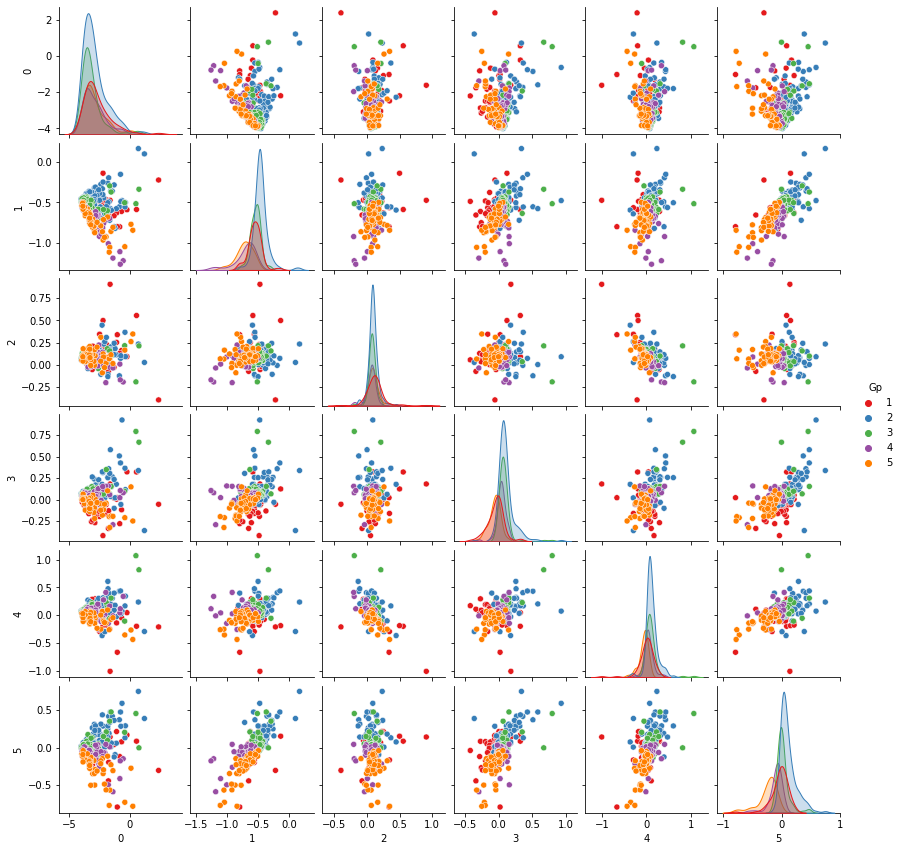

In [5]:
# Data Transformation.

# Select 'k' no of eigen vectors
k = 6
W = eigenvectors[:, :k] # Projection matrix

# Transform the original dataset
X_proj = x.dot(W)
X_proj_fin = pd.concat([X_proj, cat_data], axis=1)
X_proj_fin.to_csv('columns_heatmap.csv', index=False)
print('\nNew projection:')
print(X_proj_fin)
#X_proj_pd = pd.DataFrame(X_proj)
#print(X_proj)

sns.pairplot(data=X_proj_fin, hue='Gp', height=2, palette="Set1")
plt.plot()

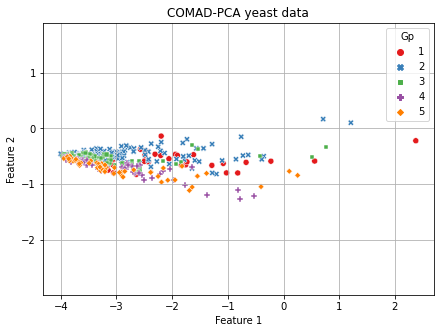

In [15]:
# Calculate the end points of the PC axes (scaled by the square root of the absolute eigenvalues)
pc_endpoints = eigenvectors * np.sqrt(np.abs(eigenvalues))
  
def Original():
    
    # Set the figure size
    plt.figure(figsize=(7, 5))

    df = pd.DataFrame(X_proj_fin)

    # Plot the DataFrame using Seaborn's scatterplot function
    sns.scatterplot(x=X_proj_fin[0], y=X_proj_fin[1],hue = X_proj_fin['Gp'], style=X_proj_fin['Gp'], data=df, palette="Set1" )

    # Show the plot
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('COMAD-PCA yeast data')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    

Original()
#Transformed()

In [7]:
X_proj_1D = X_proj.to_numpy()
#X_proj_1D = X_proj.flatten()[::-1]

# Calculate the condensed distance matrix
condensed_dist_matrix = pdist(X_proj_1D)

# Convert the condensed distance matrix to a square distance matrix
dist_matrix = pd.DataFrame(squareform(condensed_dist_matrix))

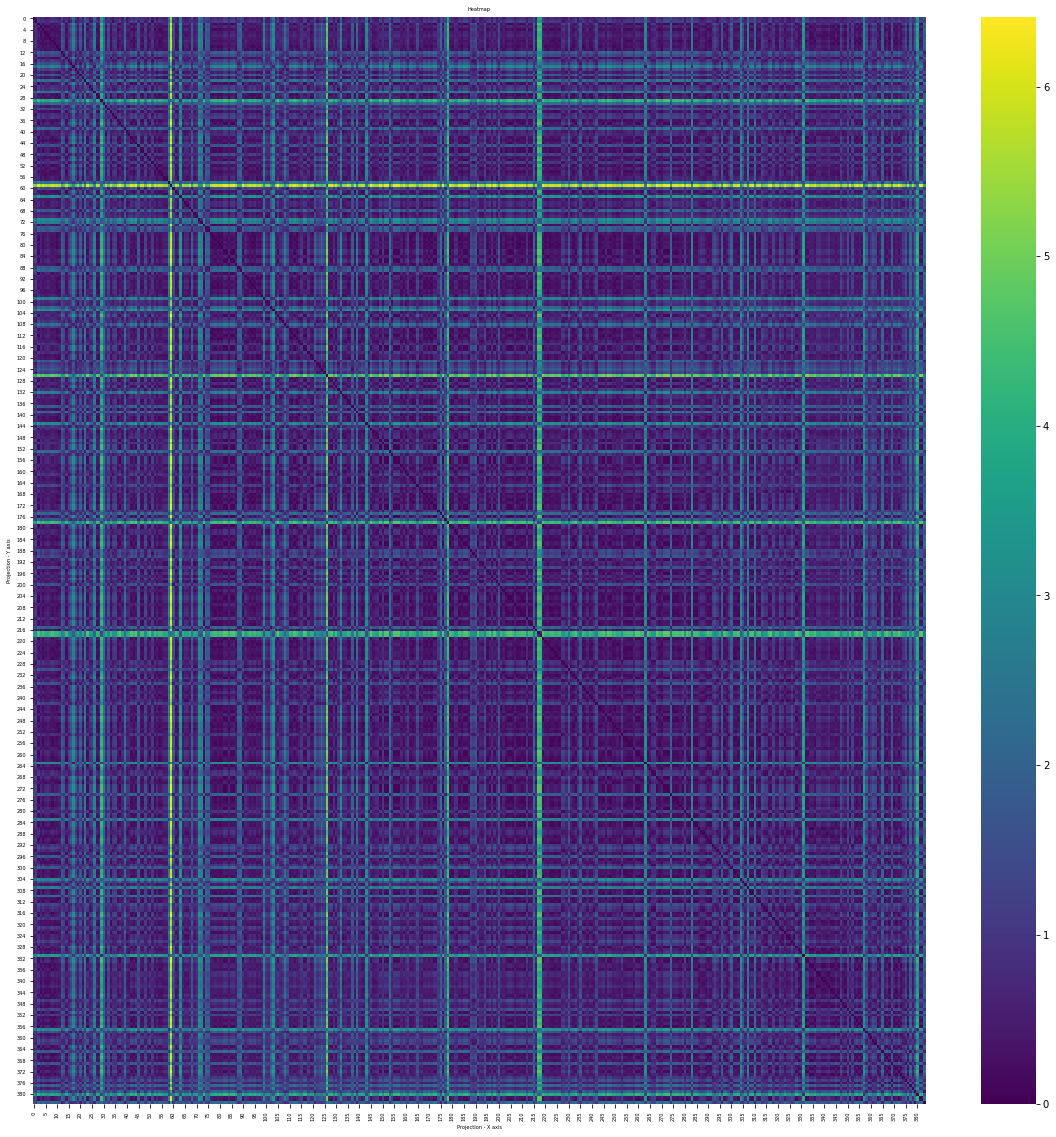

In [8]:
plt.figure(figsize=(20, 20))
sns.heatmap(dist_matrix, cmap='viridis', annot=False, annot_kws={"size": 10})

title_fontsize = 5
label_fontsize = 5

plt.title('Heatmap', fontsize=title_fontsize)
plt.xlabel('Projection - X axis', fontsize=label_fontsize)
plt.ylabel('Projection - Y axis', fontsize=label_fontsize)

ax = plt.gca()
ax.tick_params(axis='x', labelsize=label_fontsize)
ax.tick_params(axis='y', labelsize=label_fontsize)

plt.show()

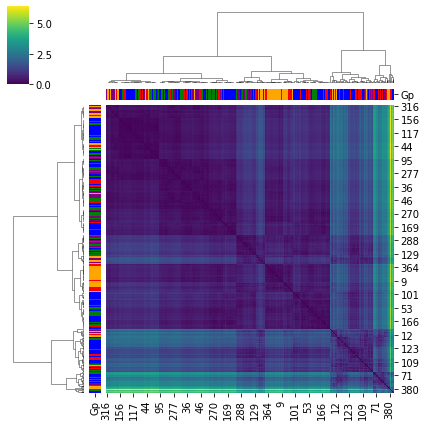

In [9]:
# Create a color mapping based on the species
species_color_mapping = X_proj_fin['Gp'].map({1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange'})

# Create a clustermap using the distance matrix and fastcluster with matching colors
linkage_matrix = fastcluster.linkage(condensed_dist_matrix, method='ward')
sns.clustermap(dist_matrix, cmap='viridis', figsize=(6, 6), row_linkage=linkage_matrix, col_linkage=linkage_matrix,
               row_colors=species_color_mapping, col_colors=species_color_mapping)

# Show the plot
plt.show()

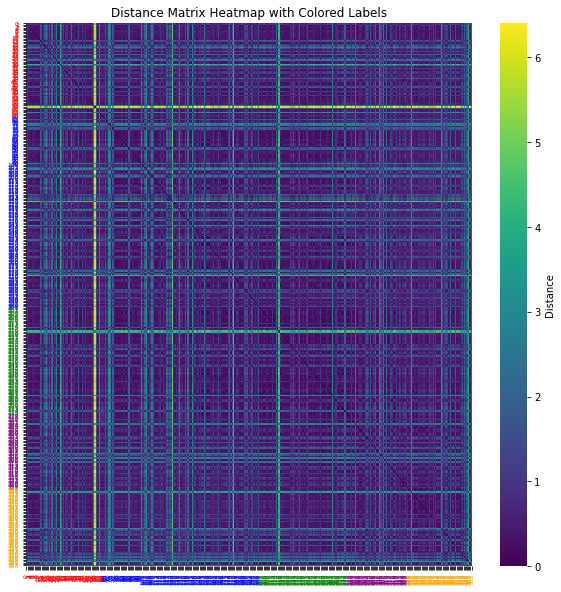

In [10]:
# Create a custom color mapping based on the species
species_color_mapping = X_proj_fin['Gp'].map({1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange'})
# Plot the distance matrix heatmap with colored labels
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dist_matrix, cmap='viridis', ax=ax,
            cbar_kws={'label': 'Distance'})

# Set the tick labels and colors
ax.set_xticks(np.arange(dist_matrix.shape[0]) + 0.5)
ax.set_yticks(np.arange(dist_matrix.shape[0]) + 0.5)
ax.set_xticklabels(species_color_mapping.index, rotation=90, fontsize=6)
ax.set_yticklabels(species_color_mapping.index, rotation=0, fontsize=6)

# Color the tick labels
for tick, color in zip(ax.get_xticklabels(), species_color_mapping):
    tick.set_color(color)

for tick, color in zip(ax.get_yticklabels(), species_color_mapping):
    tick.set_color(color)

# Show the plot
plt.title('Distance Matrix Heatmap with Colored Labels')
plt.show()

In [11]:
# Dump to CSV

dist_matrix.to_csv('COMAD-yeast.csv', index=False)

In [12]:
# Load Dataframe for K-nn
knn_df = X_proj_fin

# Select the columns corresponding to the features
features = knn_df[[0, 1, 2, 3, 4, 5]]

# Create a NearestNeighbors object
nbrs = NearestNeighbors(n_neighbors=21, algorithm='ball_tree').fit(features)

# Find the point in the dataset corresponding to point 200
point_200 = knn_df[knn_df['Main'] == 'YNL310c'][[0, 1, 2, 3, 4, 5]]

# Find the 10 nearest neighbors
distances, indices = nbrs.kneighbors(point_200)

# Print the ids and point numbers of the 10 nearest neighbors
neighbors_df = pd.DataFrame(columns=['Neighbor', 'ID', 'Gp'])
for i in range(1, len(indices[0])):
    neighbor_index = indices[0][i]
    neighbor_id = knn_df.loc[neighbor_index, 'Main']
    neighbor_point_no = knn_df.index[neighbor_index]
    neighbor_point_group = knn_df.loc[neighbor_index, 'Gp']
    print(f"Neighbor {i}: ID = {neighbor_id}, Point No. = {neighbor_point_no}, Gp = {neighbor_point_group}")
    neighbors_df = neighbors_df.append({ 'Neighbor': i, 'ID': neighbor_id, 'Point No Knn': neighbor_point_no, 'Gp': neighbor_point_group}, ignore_index=True)

# Number of nearest neighbors
k = 20

# Calculate the k-nearest neighbors from the distance matrix
nearest_neighbors = dist_matrix.iloc[200].values.argsort()[1:k+1]

# Create a DataFrame with the indices of the k-nearest neighbors
nearest_neighbors_df = pd.DataFrame(nearest_neighbors, columns=['Point No Dist Matrix'])
column_to_add = nearest_neighbors_df['Point No Dist Matrix']
neighbors_df = neighbors_df.join(column_to_add)

# Dump the dataset as a .csv file
neighbors_df.to_csv('knn_comad_pca.csv', index=False)

Neighbor 1: ID = YKL163w, Point No. = 60, Gp = 1
Neighbor 2: ID = YOR065w, Point No. = 18, Gp = 1
Neighbor 3: ID = YDL095w, Point No. = 235, Gp = 3
Neighbor 4: ID = YLR032w, Point No. = 109, Gp = 2
Neighbor 5: ID = YDR493w, Point No. = 190, Gp = 2
Neighbor 6: ID = YBR104w, Point No. = 293, Gp = 4
Neighbor 7: ID = YKL150w, Point No. = 16, Gp = 1
Neighbor 8: ID = YKL066W, Point No. = 274, Gp = 3
Neighbor 9: ID = YPR167C, Point No. = 358, Gp = 5
Neighbor 10: ID = YML061c, Point No. = 121, Gp = 2
Neighbor 11: ID = YBR052c, Point No. = 48, Gp = 1
Neighbor 12: ID = YPR120c, Point No. = 68, Gp = 2
Neighbor 13: ID = YDR309c, Point No. = 177, Gp = 2
Neighbor 14: ID = YNL046w, Point No. = 45, Gp = 1
Neighbor 15: ID = YDL124w, Point No. = 188, Gp = 2
Neighbor 16: ID = YGR183c, Point No. = 20, Gp = 1
Neighbor 17: ID = YER001w, Point No. = 230, Gp = 3
Neighbor 18: ID = YKL069W, Point No. = 326, Gp = 4
Neighbor 19: ID = YGL055w, Point No. = 32, Gp = 1
Neighbor 20: ID = YOL019w, Point No. = 242, Gp =

In [13]:
neighbors_df

,Neighbor,ID,Gp,Point No Knn,Point No Dist Matrix
0,1,YKL163w,1,60.0,60
1,2,YOR065w,1,18.0,18
2,3,YDL095w,3,235.0,235
3,4,YLR032w,2,109.0,109
4,5,YDR493w,2,190.0,190
5,6,YBR104w,4,293.0,293
6,7,YKL150w,1,16.0,16
7,8,YKL066W,3,274.0,274
8,9,YPR167C,5,358.0,358
9,10,YML061c,2,121.0,121
